In [1]:
import numpy as np
rng = np.random.default_rng(seed = 37)

import matplotlib.pyplot as plt
import os
import math 
import torch as t
import torchvision as tv
from torchvision.transforms import v2

from tqdm import tqdm

import sys
sys.path.append('/vast/xj2173/diffeo/utils')

device = t.device("cuda") if t.cuda.is_available() else t.device("cpu")
print(f'Using {device} for inference')

Using cuda for inference


In [2]:
visualization_transforms = v2.Compose(
    [v2.ToImage(),
     v2.ToDtype(t.float32, scale=True),
     v2.Resize(256),
     v2.CenterCrop(224),
     ])

fav_pic_index = 28621
data_root = '/vast/xj2173/diffeo/imagenet'
imagenet_val_visual = tv.datasets.ImageNet(data_root, split = 'val', transform = visualization_transforms)
fav_image = imagenet_val_visual[fav_pic_index][0]

toImage = v2.ToPILImage()

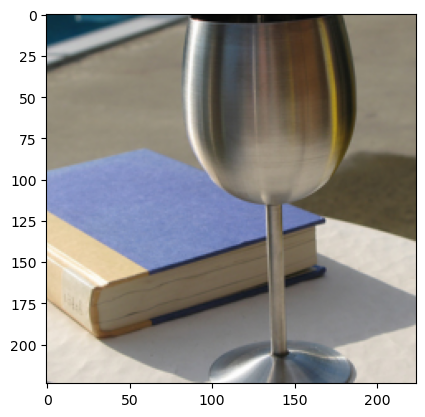

In [3]:
plt.imshow(toImage(fav_image))

In [3]:
from utils.diffeo_container import sparse_diffeo_container


sparse_diffeos = sparse_diffeo_container(224, 224)
time = t.linspace(0, math.pi, 180)
At = np.transpose(np.array([[t.sin(2 * time)/4, (-t.abs(time - math.pi/2)+math.pi/2)/3],[-t.sin(time)**2 / 4, -time*t.sin(time)**2 / 5]]), (2,0,1))
Bt = np.transpose(np.array([[(-t.abs(time - math.pi/2)+math.pi/2)/4 ,time*t.sin(time)**2 / 5],[t.sin(2 * time)/4, -t.sin(time)**2 / 4]]), (2,0,1))

sparse_diffeos.A.append(t.Tensor(At))
sparse_diffeos.B.append(t.Tensor(Bt))

sparse_diffeos.get_all_grid()

sparse_diffeos.to(device)

inverse_diffeo = sparse_diffeos.get_inverse_grid(base_learning_rate = 500, mode = 'bilinear')

  0%|          | 0/10000 [00:00<?, ?it/s]/home/xj2173/vast/miniconda3/envs/diffeo/lib/python3.11/site-packages/torch/nn/functional.py:4343: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
 55%|█████▌    | 5519/10000 [00:22<00:18, 247.57it/s]


In [29]:
sparse_diffeos.B[0][100].abs().sum()

tensor(1.0175)

In [4]:
loop_path = t.nn.functional.grid_sample(fav_image.unsqueeze(0).repeat((sparse_diffeos.length),1,1,1).to(device), sparse_diffeos[0])

/home/xj2173/vast/miniconda3/envs/diffeo/lib/python3.11/site-packages/torch/nn/functional.py:4343: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


In [42]:
images = []
for image in loop_path:
    images.append(toImage(image))

images[0].save('../data/output.gif', save_all=True, append_images=images[1:], duration=1.5, loop=0)

In [7]:
loop_path.device

device(type='cuda', index=0)

In [14]:
inv_loop_path = t.nn.functional.grid_sample(loop_path, sparse_diffeos.inverse[0], mode = 'nearest')

/home/xj2173/vast/miniconda3/envs/diffeo/lib/python3.11/site-packages/torch/nn/functional.py:4343: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


In [15]:
t.nn.MSELoss()(inv_loop_path, fav_image.unsqueeze(0).repeat((sparse_diffeos.length),1,1,1).to(device))

tensor(0.0049, device='cuda:0')

In [30]:
t.Tensor([t.nn.functional.normalize(inv_loop_path[0].flatten(), dim = 0) @ t.nn.functional.normalize(inv_loop.flatten(), dim = 0) for inv_loop in inv_loop_path]).mean()

tensor(1.0000)

In [39]:
inv_images = []
for image in inv_loop_path:
    inv_images.append(toImage(image))

inv_images[0].save('data/inv_output_bicubic.gif', save_all=True, append_images=inv_images[1:], duration=1.5, loop=0)

In [40]:
difference = t.linalg.vector_norm(fav_image.unsqueeze(0).repeat((sparse_diffeos.length),1,1,1).to(device) - inv_loop_path, dim = 1, keepdim = True) / t.linalg.vector_norm(fav_image.unsqueeze(0).repeat((sparse_diffeos.length),1,1,1).to(device), dim = 1, keepdim = True)

In [41]:
diff_images = []
for image in difference:
    diff_images.append(toImage(image))

diff_images[0].save('data/diff_output_bicubic.gif', save_all=True, append_images=diff_images[1:], duration=1.5, loop=0)

In [50]:
activation = {}
def getActivation(name):
    # the hook signature
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook
handles = []

def retrieve_layer_activation(model, input, layer_index):
  if len(input) == 3: input = input[None, :, :, :]

  layers = list(model.children())
  layers_flat = flatten(layers)

  for index in layer_index:
    handles.append(layers_flat[index - 1].register_forward_hook(getActivation(str(index))))

  with t.no_grad(): model(input)
  for handle in handles: handle.remove()

  return

def flatten(array):
    result = []
    for element in array:
        if hasattr(element, "__iter__"):
            result.extend(flatten(element))
        else:
            result.append(element)
    return result

In [51]:
ENV2 = tv.models.efficientnet_v2_s(weights = tv.models.EfficientNet_V2_S_Weights.DEFAULT).to(device)
ENV2.eval();
for param in ENV2.parameters():
    param.requires_grad = False
inference_transform = tv.models.EfficientNet_B0_Weights.IMAGENET1K_V1.transforms()
inference_transforms = v2.Compose([
    lambda x: x.convert('RGB'),
    inference_transform,
])
imagenet_val_inference = tv.datasets.ImageNet(data_root, split = 'val', transform = inference_transforms)
fav_pic_inf = imagenet_val_inference[fav_pic_index][0].unsqueeze(0)

In [83]:
from copy import deepcopy

distorted_list = t.nn.functional.grid_sample(fav_pic_inf.repeat(len(sparse_diffeos), 1, 1, 1).to(device), sparse_diffeos[0].to(device))
retrieve_layer_activation(ENV2, distorted_list, [5,9,13,19,28,36,43,46,49])
distort_activation = deepcopy(activation)

/home/xj2173/vast/miniconda3/envs/diffeo/lib/python3.11/site-packages/torch/nn/functional.py:4343: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


In [19]:
from utils.diffeo_container import diffeo_container

inv_diffeos = diffeo_container(224, 224, inv_grid.cpu())
inv_diffeos

diffeo_container(x_res=224, y_res=224, with 180 diffeos)

In [74]:
inv_diffeos.up_down_sample(56, 56)
inv_diffeos.up_down_sample(28, 28)
inv_diffeos.up_down_sample(14, 14)
inv_diffeos.up_down_sample( 7,  7)
inv_diffeos.children

[diffeo_container(x_res=56, y_res=56, with 1 diffeos),
 diffeo_container(x_res=28, y_res=28, with 1 diffeos),
 diffeo_container(x_res=14, y_res=14, with 1 diffeos),
 diffeo_container(x_res=7, y_res=7, with 1 diffeos)]

In [34]:
activation.keys()

dict_keys(['5', '9', '13', '19', '28', '36', '43', '46', '49'])

In [73]:
activation['13'].shape

torch.Size([180, 64, 28, 28])

In [101]:
activation_layer_9_inv = t.nn.functional.grid_sample(distort_activation['9'].cpu(), inv_diffeos.children[0][0][0].cpu())
activation_layer_13_inv = t.nn.functional.grid_sample(distort_activation['13'].cpu(), inv_diffeos.children[1][0][0].cpu())
activation_layer_28_inv = t.nn.functional.grid_sample(distort_activation['28'].cpu(), inv_diffeos.children[2][0][0].cpu())
activation_layer_36_inv = t.nn.functional.grid_sample(distort_activation['36'].cpu(), inv_diffeos.children[3][0][0].cpu())

/home/xj2173/vast/miniconda3/envs/diffeo/lib/python3.11/site-packages/torch/nn/functional.py:4343: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


In [32]:
activation_layer_9_inv.shape

torch.Size([180, 48, 56, 56])

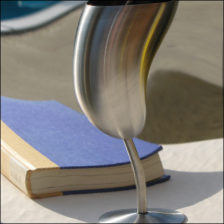

In [118]:
images[120]

In [97]:
activation_layer_9_inv[100].shape

torch.Size([48, 56, 56])

In [126]:
for j, image in enumerate(activation_layer_9_inv):
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
    fig.subplots_adjust(right=0.85)

    # Create a shared colorbar
    vmin = min(d.min() for d in image[::5]) * 0.85
    vmin = -17
    vmax = max(d.max() for d in image[::5]) * 0.85
    vmax = 17
    cmap = plt.get_cmap('viridis')

    for i, ax in enumerate(axes.flat):
        im = ax.imshow(image[::5][i].T, vmin=vmin, vmax=vmax, cmap=cmap)
        if i == 0: im = ax.imshow(images[j])
        ax.set_xticks([])
        ax.set_yticks([])

    # Adjust the colorbar to be placed correctly
    cbar_ax = fig.add_axes([0.87, 0.15, 0.03, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    fig.suptitle('Layer 9 activation after inverse transformation', y=0.9)
    plt.savefig(f'../data/temp_layer9/figure_layer9_{j:03}.png')
    plt.close()

In [128]:
from PIL import Image

file_names = [f"../data/temp_layer9/figure_layer9_{i:03}.png" for i in range(180)]

# Read images and create animation
layer_9_images = [Image.open(f) for f in file_names]

# Adjust the fps value as needed
layer_9_images[0].save('../data/layer9_inv_output.gif', save_all=True, append_images=layer_9_images[1:], duration=1.5, loop=0)

In [127]:
for j, image in enumerate(activation_layer_13_inv):
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))
    fig.subplots_adjust(right=0.85)

    # Create a shared colorbar
    vmin = min(d.min() for d in image[::4]) * 0.85
    vmin = -17
    vmax = max(d.max() for d in image[::4]) * 0.85
    vmax = 17
    cmap = plt.get_cmap('viridis')

    for i, ax in enumerate(axes.flat):
        im = ax.imshow(image[::4][i].T, vmin=vmin, vmax=vmax, cmap=cmap)
        if i == 0: im = ax.imshow(images[j])
        ax.set_xticks([])
        ax.set_yticks([])

    # Adjust the colorbar to be placed correctly
    cbar_ax = fig.add_axes([0.87, 0.15, 0.03, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    fig.suptitle('Layer 13 activation after inverse transformation', y=0.9)
    plt.savefig(f'../data/temp_layer13/figure_layer13_{j:03}.png')
    plt.close()

In [129]:
from PIL import Image

file_names = [f"../data/temp_layer13/figure_layer13_{i:03}.png" for i in range(180)]

# Read images and create animation
layer_13_images = [Image.open(f) for f in file_names]

# Adjust the fps value as needed
layer_13_images[0].save('../data/layer13_inv_output.gif', save_all=True, append_images=layer_13_images[1:], duration=1.5, loop=0)

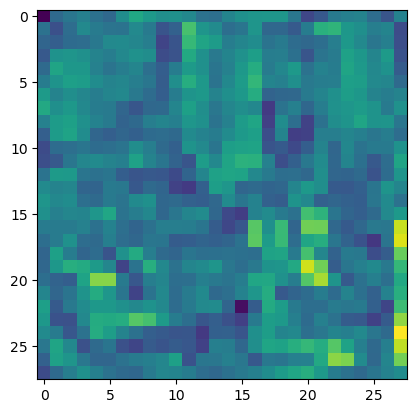

In [78]:
plt.imshow(activation_layer_13_inv[10,50].cpu().T)

In [145]:
for j, image in enumerate(activation_layer_28_inv):
    fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(10, 10))
    fig.subplots_adjust(right=0.85)

    # Create a shared colorbar
    vmin = min(d.min() for d in image[::4]) * 0.85
    vmin = -15
    vmax = max(d.max() for d in image[::4]) * 0.85
    vmax = 20
    cmap = plt.get_cmap('viridis')

    for i, ax in enumerate(axes.flat):
        im = ax.imshow(image[::4][i].T, vmin=vmin, vmax=vmax, cmap=cmap)
        if i == 0: im = ax.imshow(images[j])
        ax.set_xticks([])
        ax.set_yticks([])

    # Adjust the colorbar to be placed correctly
    cbar_ax = fig.add_axes([0.87, 0.15, 0.03, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    fig.suptitle('Layer 28 activation after inverse transformation', y=0.9)
    plt.savefig(f'../data/temp_layer28/figure_layer28_{j:03}.png')
    plt.close()

In [146]:
from PIL import Image

file_names = [f"../data/temp_layer28/figure_layer28_{i:03}.png" for i in range(180)]

# Read images and create animation
layer_28_images = [Image.open(f) for f in file_names]

# Adjust the fps value as needed
layer_28_images[0].save('../data/layer28_inv_output.gif', save_all=True, append_images=layer_28_images[1:], duration=1.5, loop=0)

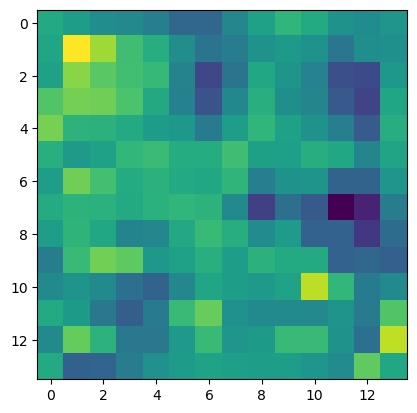

In [72]:
plt.imshow(activation_layer_28_inv[10,50].cpu().T)

In [147]:
for j, image in enumerate(activation_layer_36_inv):
    fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(10, 10))
    fig.subplots_adjust(right=0.85)

    # Create a shared colorbar
    vmin = min(d.min() for d in image[::4]) * 0.85
    vmin = -10
    vmax = max(d.max() for d in image[::4]) * 0.85
    vmax = 10
    cmap = plt.get_cmap('viridis')

    for i, ax in enumerate(axes.flat):
        im = ax.imshow(image[::4][i].T, vmin=vmin, vmax=vmax, cmap=cmap)
        if i == 0: im = ax.imshow(images[j])
        ax.set_xticks([])
        ax.set_yticks([])

    # Adjust the colorbar to be placed correctly
    cbar_ax = fig.add_axes([0.87, 0.15, 0.03, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    fig.suptitle('Layer 36 activation after inverse transformation', y=0.9)
    plt.savefig(f'../data/temp_layer36/figure_layer36_{j:03}.png')
    plt.close()

In [148]:
from PIL import Image

file_names = [f"../data/temp_layer36/figure_layer36_{i:03}.png" for i in range(180)]

# Read images and create animation
layer_36_images = [Image.open(f) for f in file_names]

# Adjust the fps value as needed
layer_36_images[0].save('../data/layer36_inv_output.gif', save_all=True, append_images=layer_36_images[1:], duration=1.5, loop=0)

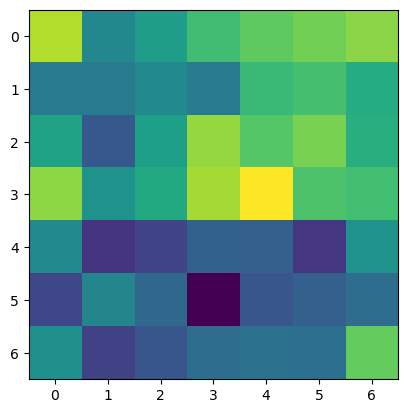

In [64]:
plt.imshow(activation_layer_36_inv[100,50].cpu().T)